In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [4]:
class State(TypedDict):
    # 메시지 목록
    messages: Annotated[list, add_messages]
    # 사람에게 질문할지 여부를 묻는 상태 추가
    ask_human: bool

In [ ]:
from pydantic import BaseModel


class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str


In [18]:
from langchain_openai import ChatOpenAI

# 도구 추가
tool = TavilySearch(max_results=3)

# 도구 목록 추가(HumanRequest 도구)
tools = [tool, HumanRequest]

# LLM 추가
llm = ChatOpenAI(model="gpt-4o", temperature=0)

# 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    # LLM 도구 호출을 통한 응답 생성
    response = llm_with_tools.invoke(state["messages"])

    # 사람에게 질문할지 여부 초기화
    ask_human = False

    # 도구 호출이 있고 이름이 'HumanRequest' 인 경우
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # 메시지와 ask_human 상태 반환
    return {"messages": [response], "ask_human": ask_human}


In [19]:
# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
graph_builder.add_node("tools", ToolNode(tools=[tool]))


In [20]:
from langchain_core.messages import AIMessage, ToolMessage


# 응답 메시지 생성(ToolMessage 생성을 위한 함수)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


# 인간 노드 처리
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 사람으로부터 응답이 없는 경우
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # 새 메시지 추가
        "messages": new_messages,
        # 플래그 해제
        "ask_human": False,
    }


# 그래프에 인간 노드 추가
graph_builder.add_node("human", human_node)


In [21]:
from langgraph.graph import END


# 다음 노드 선택
def select_next_node(state: State):
    # 인간에게 질문 여부 확인
    if state["ask_human"]:
        return "human"
    # 이전과 동일한 경로 설정
    return tools_condition(state)


# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)


In [22]:
# 엣지 추가: 'tools'에서 'chatbot'으로
graph_builder.add_edge("tools", "chatbot")

# 엣지 추가: 'human'에서 'chatbot'으로
graph_builder.add_edge("human", "chatbot")

# 엣지 추가: START에서 'chatbot'으로
graph_builder.add_edge(START, "chatbot")

# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일: 메모리 체크포인터 사용
graph = graph_builder.compile(
    checkpointer=memory,
    # 'human' 이전에 인터럽트 설정
    interrupt_before=["human"],
)


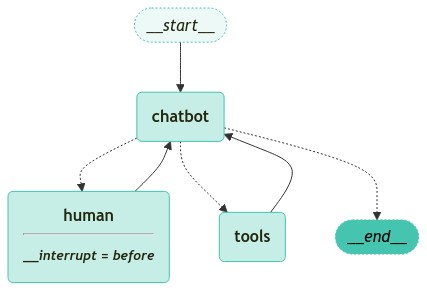

In [23]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)


In [24]:
# user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 검색해서 답변하세요" (Human 이 아닌 웹검색을 수행하는 경우)
user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?"

# config 설정
config = {"configurable": {"thread_id": "1"}}

# 스트림 또는 호출의 두 번째 위치 인수로서의 구성
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()


================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_7iTG1GtW0vPaRU8eKZyTV2oF)
 Call ID: call_7iTG1GtW0vPaRU8eKZyTV2oF
  Args:
    request: AI 에이전트를 구축하기 위해 전문가의 도움을 요청하고 싶습니다. 관련 전문가를 찾거나 연결할 수 있는 방법을 안내해 주세요.


In [25]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태 접근
snapshot.next


('human',)

In [26]:
# AI 메시지 추출
ai_message = snapshot.values["messages"][-1]

# 인간 응답 생성
human_response = (
    "전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. "
    "단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. "
    "https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다."
)

# 도구 메시지 생성
tool_message = create_response(human_response, ai_message)

# 그래프 상태 업데이트
graph.update_state(config, {"messages": [tool_message]})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9bf7a-bf09-6647-8002-3cd3d2273c38'}}

In [27]:
# 그래프에서 이벤트 스트림 생성
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하기 위해 전문가의 도움을 원하신다면, LangGraph를 확인해 보시는 것을 추천드립니다. 이는 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다.


In [29]:
# 최종 상태 확인
state = graph.get_state(config)

# 단계별 메시지 출력
for message in state.values["messages"]:
    message.pretty_print()


================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_7iTG1GtW0vPaRU8eKZyTV2oF)
 Call ID: call_7iTG1GtW0vPaRU8eKZyTV2oF
  Args:
    request: AI 에이전트를 구축하기 위해 전문가의 도움을 요청하고 싶습니다. 관련 전문가를 찾거나 연결할 수 있는 방법을 안내해 주세요.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

AI 에이전트를 구축하기 위해 전문가의 도움을 원하신다면, LangGraph를 확인해 보시는 것을 추천드립니다. 이는 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. 더 많은 정보는 [여기](https://wikidocs.net/233785)에서 확인하실 수 있습니다.
